#### Get the Data


In [124]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
import graphviz
import plotly.graph_objs as go



In [5]:
# Read the data
df = pd.read_csv("credit_risk_dataset.csv")
# Print the first 5 rows of the dataframe.
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
# Print categorical columns
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"{column}: {len(df[column].unique())}")

person_home_ownership: 4
loan_intent: 6
loan_grade: 7
cb_person_default_on_file: 2


#### Data cleaning

In [7]:
# Print numerical columns
num = df.describe().T
# Print descriptive statistics of numerical columns
num.style.background_gradient(cmap='Oranges')

,count,mean,std,min,25%,50%,75%,max
person_age,32581.000000,27.734600,6.348078,20.000000,23.000000,26.000000,30.000000,144.000000
person_income,32581.000000,66074.848470,61983.119168,4000.000000,38500.000000,55000.000000,79200.000000,6000000.000000
person_emp_length,31686.000000,4.789686,4.142630,0.000000,2.000000,4.000000,7.000000,123.000000
loan_amnt,32581.000000,9589.371106,6322.086646,500.000000,5000.000000,8000.000000,12200.000000,35000.000000
loan_int_rate,29465.000000,11.011695,3.240459,5.420000,7.900000,10.990000,13.470000,23.220000
loan_status,32581.000000,0.218164,0.413006,0.000000,0.000000,0.000000,0.000000,1.000000
loan_percent_income,32581.000000,0.170203,0.106782,0.000000,0.090000,0.150000,0.230000,0.830000
cb_person_cred_hist_length,32581.000000,5.804211,4.055001,2.000000,3.000000,4.000000,8.000000,30.000000


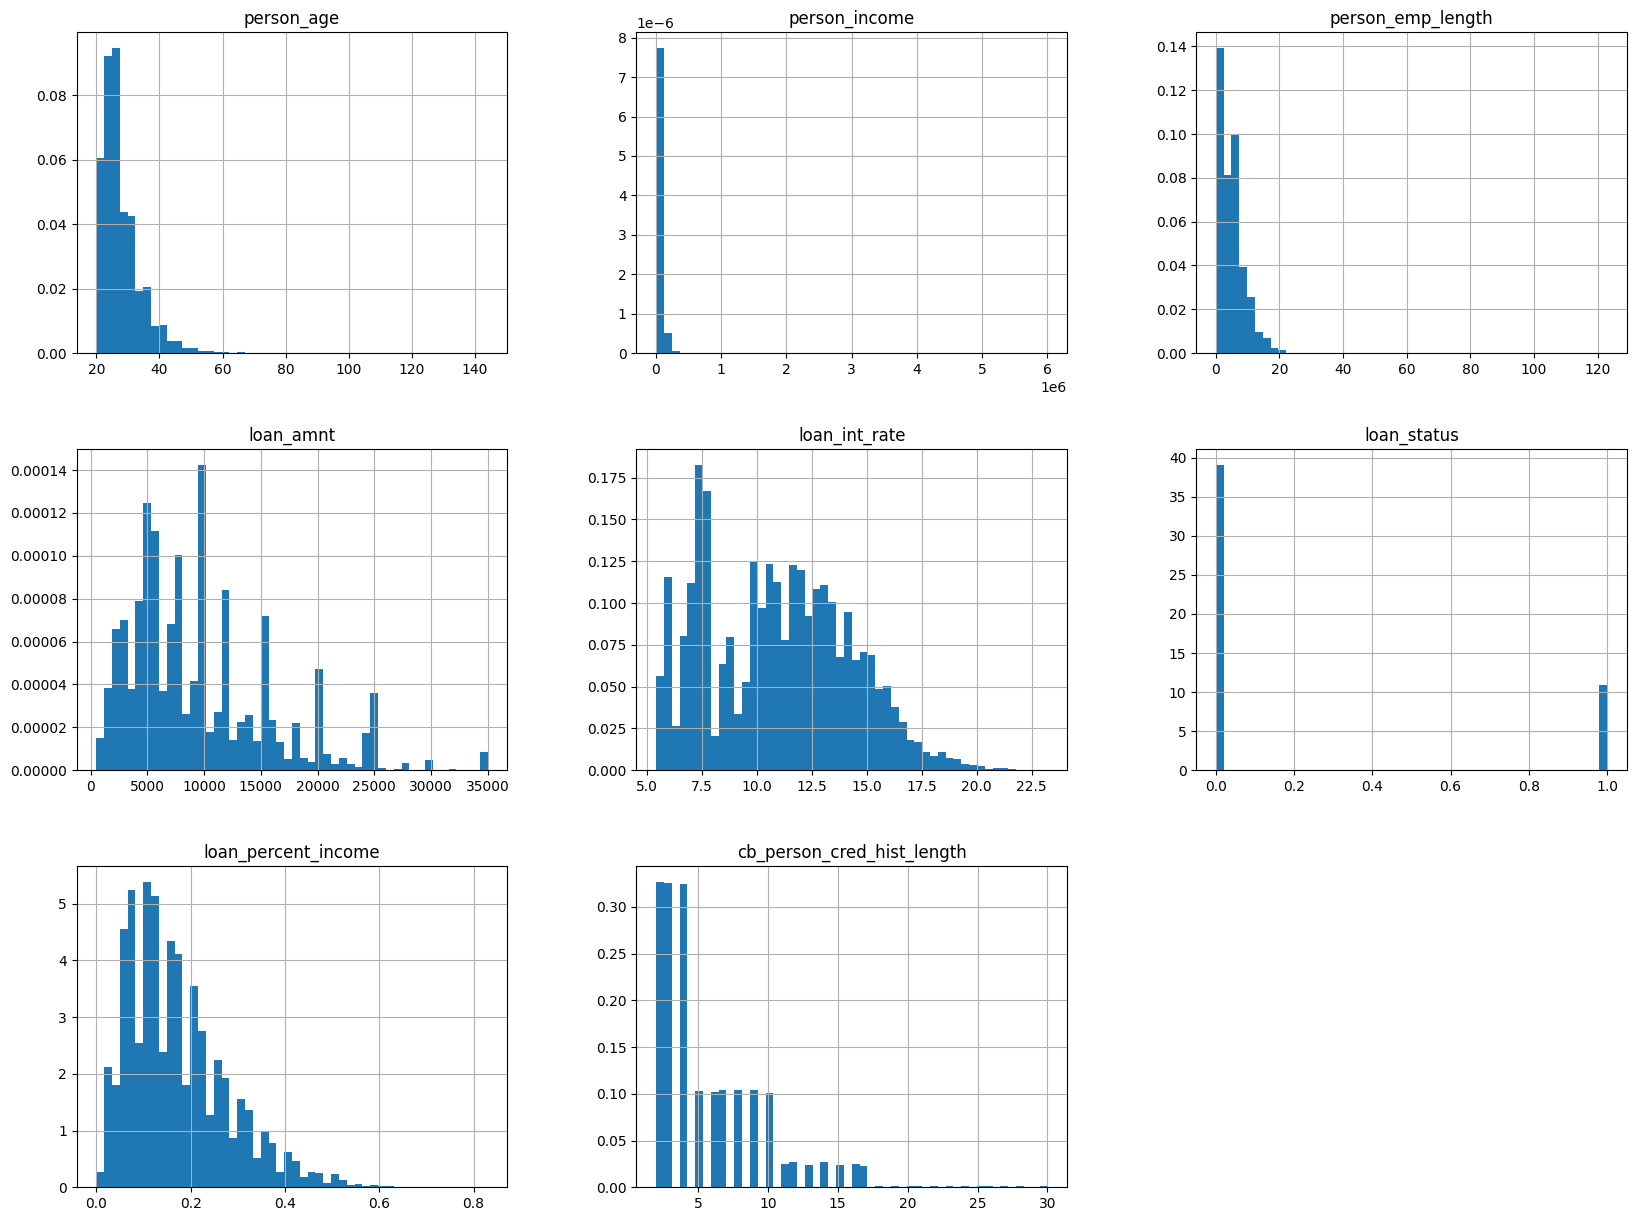

In [8]:
# Print the number of missing values in each column
df.hist(bins=50, figsize=(20,15), density = True)
plt.show()

In [9]:
# Print categorical variables
cat = df.describe(include="object").T
cat.style.background_gradient(cmap='Oranges')


,count,unique,top,freq
person_home_ownership,32581,4,RENT,16446
loan_intent,32581,6,EDUCATION,6453
loan_grade,32581,7,A,10777
cb_person_default_on_file,32581,2,N,26836


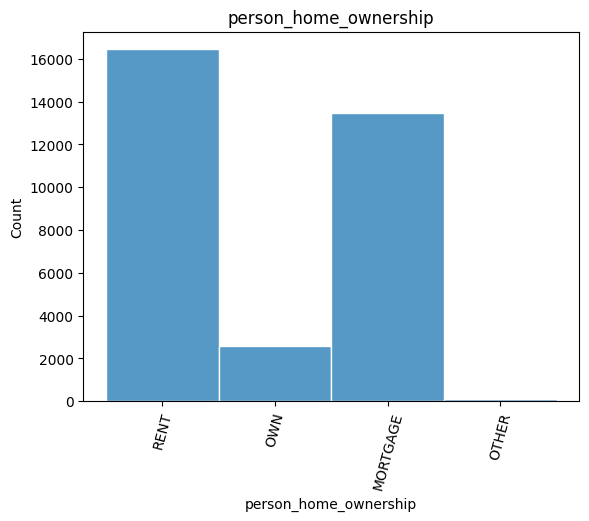

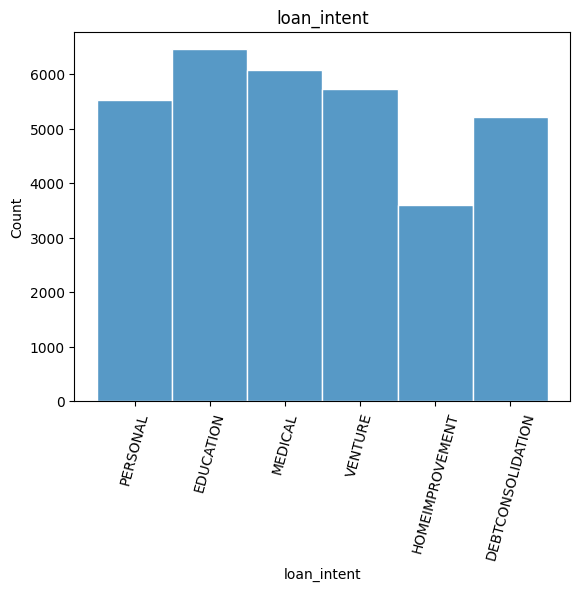

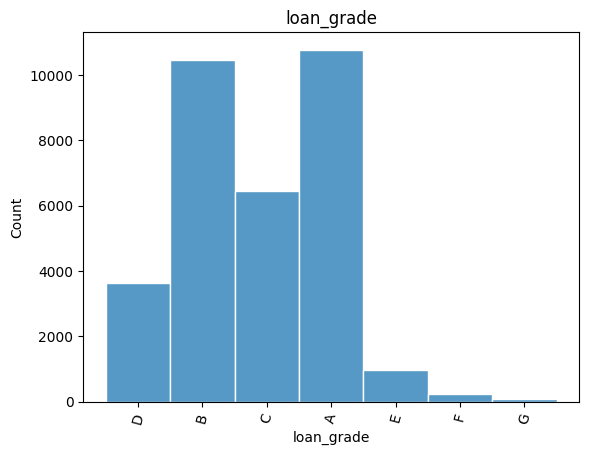

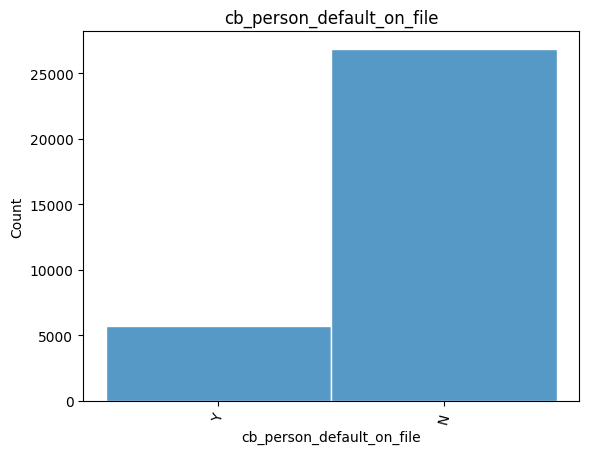

In [10]:
# Print histogram of categorical variables
for var in cat.index:
    sns.histplot(df[var], bins=50, edgecolor='white')
    plt.xticks(rotation=75)
    plt.title(var)
    plt.show()

#### Drop the missing values

In [11]:
# Print the number of missing values in each column
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [12]:
# Drop missing values
df.dropna(axis=0, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


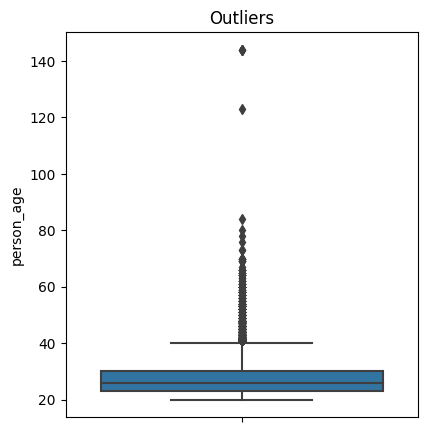

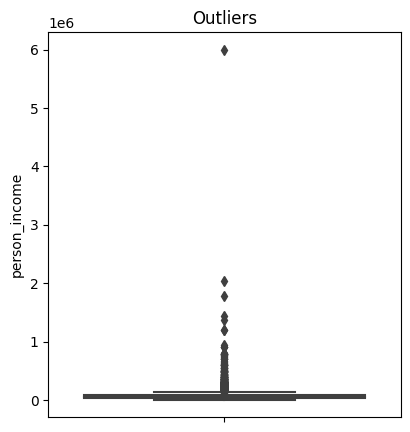

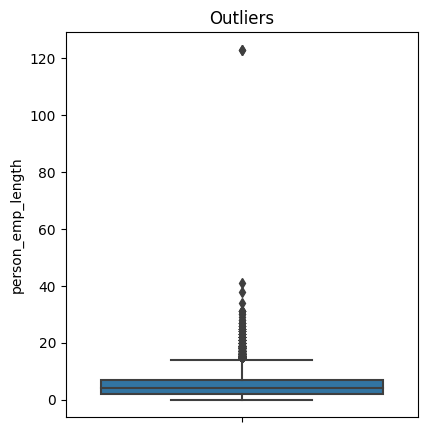

In [123]:
#  Finding the outliers
def plot_comparison(data):
    plt.figure(figsize=(10, 5)) # set the size of the figure
    plt.subplot(1, 2, 1) # 1st plot in the figure
    sns.boxplot(y=data[var],orient= 'y',  ) # boxplot of the variable in the 1st plot
    plt.title('Outliers') # title of the 1st plot
plt.show()

# Visualize outliers
for var in ['person_age', 'person_income', 'person_emp_length']:
    plot_comparison(df)


In [57]:
def remove_outliers(data, vars, multiplier= 1.5):
    """
    Remove outliers from the given DataFrame using the IQR method.

    Parameters
    ----------
    data : DataFrame
        The input dataset.
    vars : list
        A list of column names for which to remove outliers.
    multiplier : float, optional
        A factor to adjust the IQR range, by default 1.5.

    Returns
    -------
    DataFrame
        A new DataFrame with outliers removed.
    """
    data_clean = data.copy() # Create a copy of the input DataFrame to avoid modifying the original data
    for var in vars:  # Iterate through each variable/column name provided in the 'vars' list
        # Calculate the first quartile (Q1) and third quartile (Q3) for the current variable
        Q1 = data_clean[var].quantile(0.05)
        Q3 = data_clean[var].quantile(0.95)

        # Calculate the interquartile range (IQR)
        IQR = Q3 - Q1

        # Calculate the lower and upper bounds for outlier detection
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        # Filter out the rows containing outliers for the current variable
        data_clean = data_clean[(data_clean[var] >= lower_bound) & (data_clean[var] <= upper_bound)]

    return data_clean  # Return the cleaned DataFrame with outliers removed

# Remove outliers from continuous variables
df_data_clean = remove_outliers(df, ["person_age", "person_income", "person_emp_length"])       

In [61]:
# Remove outliers from the given DataFrame using the z_score method.
def remove_outliers_z_score(data, vars, threshold = 3): # threshold = 3 means that we will remove the values that are more than 3 standard deviations away from the mean
    data_clean = data.copy() # Create a copy of the input DataFrame to avoid modifying the original data
    for var in vars: # Iterate through each variable/column name provided in the 'vars' list
        z_scores = np.abs(stats.zscore(data_clean[var])) # Calculate the z-scores for the current variable
        data_clean = data_clean[z_scores < threshold] # Filter out the rows containing outliers for the current variable
    return data_clean # Return the cleaned DataFrame with outliers removed
df_data_clean2 = remove_outliers_z_score(df, ["person_age", "person_income", "person_emp_length"]) # Remove outliers from continuous variables
   

In [62]:
# Remove outliers using median absolute deviation (MAD)
def remove_outliers_mad(data, vars, thereshold = 3.5):  # 3.5 is the default value
    data_clean = data.copy() # Create a copy of the input DataFrame to avoid modifying the original data
    for var in vars: # Iterate through each variable/column name provided in the 'vars' list
        median = np.median(data_clean[var]) # Calculate the median for the current variable
        mad = np.median(np.abs(data_clean[var]-median)) # Calculate the median absolute deviation (MAD) for the current variable
        if mad ==0: # If the MAD is 0, then the variable is constant and we can't remove any outliers
            continue # Skip to the next variable
        mad_z_scores = np.abs((data_clean[var]-median)/mad) # Calculate the z-scores for the current variable
        data_clean = data_clean[mad_z_scores < thereshold] # Filter out the rows containing outliers for the current variable
    return data_clean  # Return the cleaned DataFrame with outliers removed

df_data_clean3 = remove_outliers_mad(df, ["person_age", "person_income", "person_emp_length"]) # Remove outliers from continuous variables   


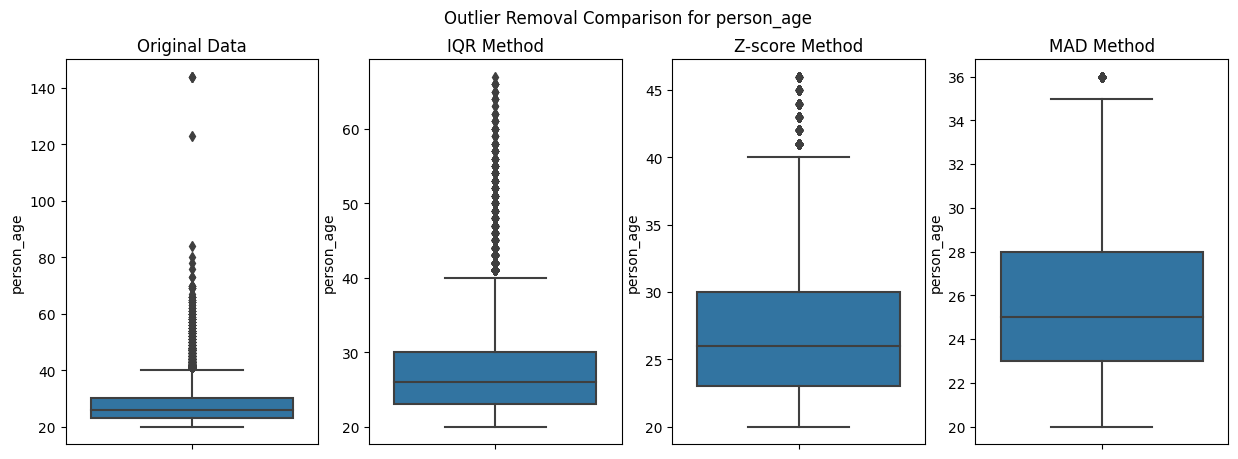

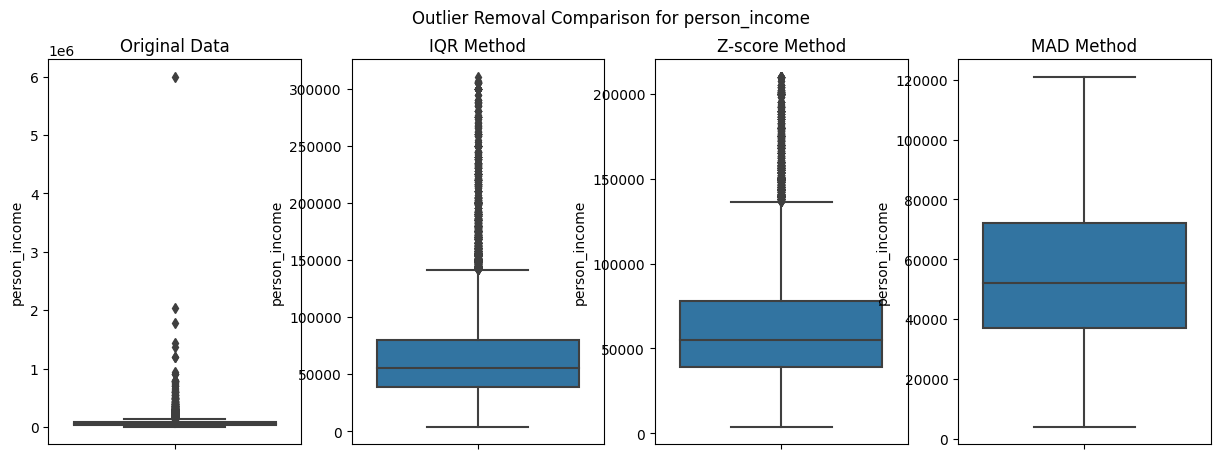

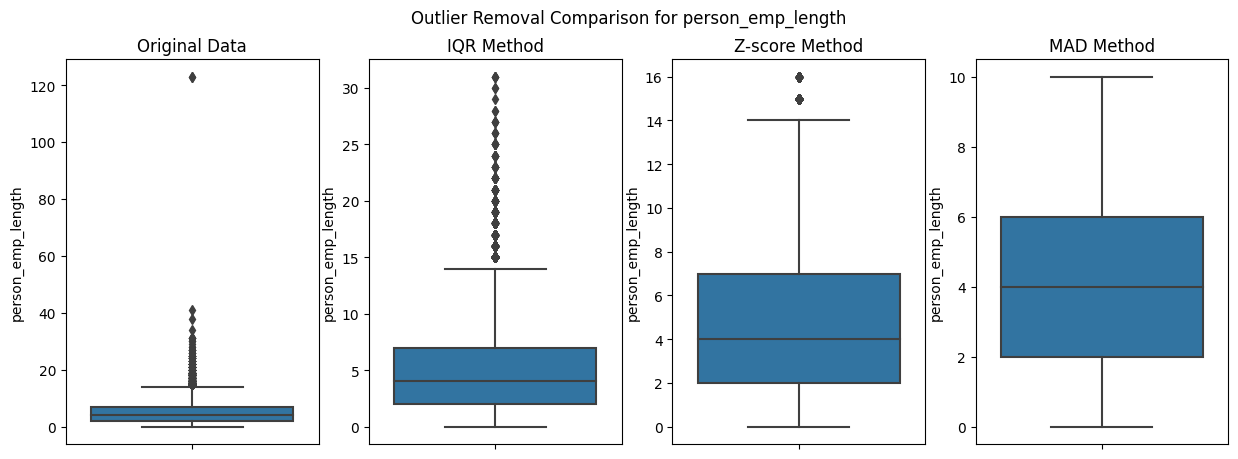

20


In [72]:

# Plot the comparison of the original data and the data with outliers removed
def plot_comparison(data, data_iqr, data_z, data_mad, var):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    sns.boxplot(y=data[var])
    plt.title('Original Data')

    plt.subplot(1, 4, 2)
    sns.boxplot(y=data_iqr[var])
    plt.title('IQR Method')

    plt.subplot(1, 4, 3)
    sns.boxplot(y=data_z[var])
    plt.title('Z-score Method')

    plt.subplot(1, 4, 4)
    sns.boxplot(y=data_mad[var])
    plt.title('MAD Method')

    plt.suptitle(f'Outlier Removal Comparison for {var}')
    plt.show()

# Remove outliers using IQR method
training_data_iqr = remove_outliers(df,['person_age', 'person_income', 'person_emp_length'], multiplier=1.5) 

# Remove outliers using Z-score method
training_data_z = remove_outliers_z_score(df, ['person_age', 'person_income', 'person_emp_length'], threshold=3)

# Remove outliers using MAD method
training_data_mad = remove_outliers_mad(df, ['person_age', 'person_income', 'person_emp_length'])

# Plot comparison for each continuous variable
for var in ['person_age', 'person_income', 'person_emp_length']:
    plot_comparison(df, training_data_iqr, training_data_z, training_data_mad, var)

print(training_data_iqr['person_age'].min())


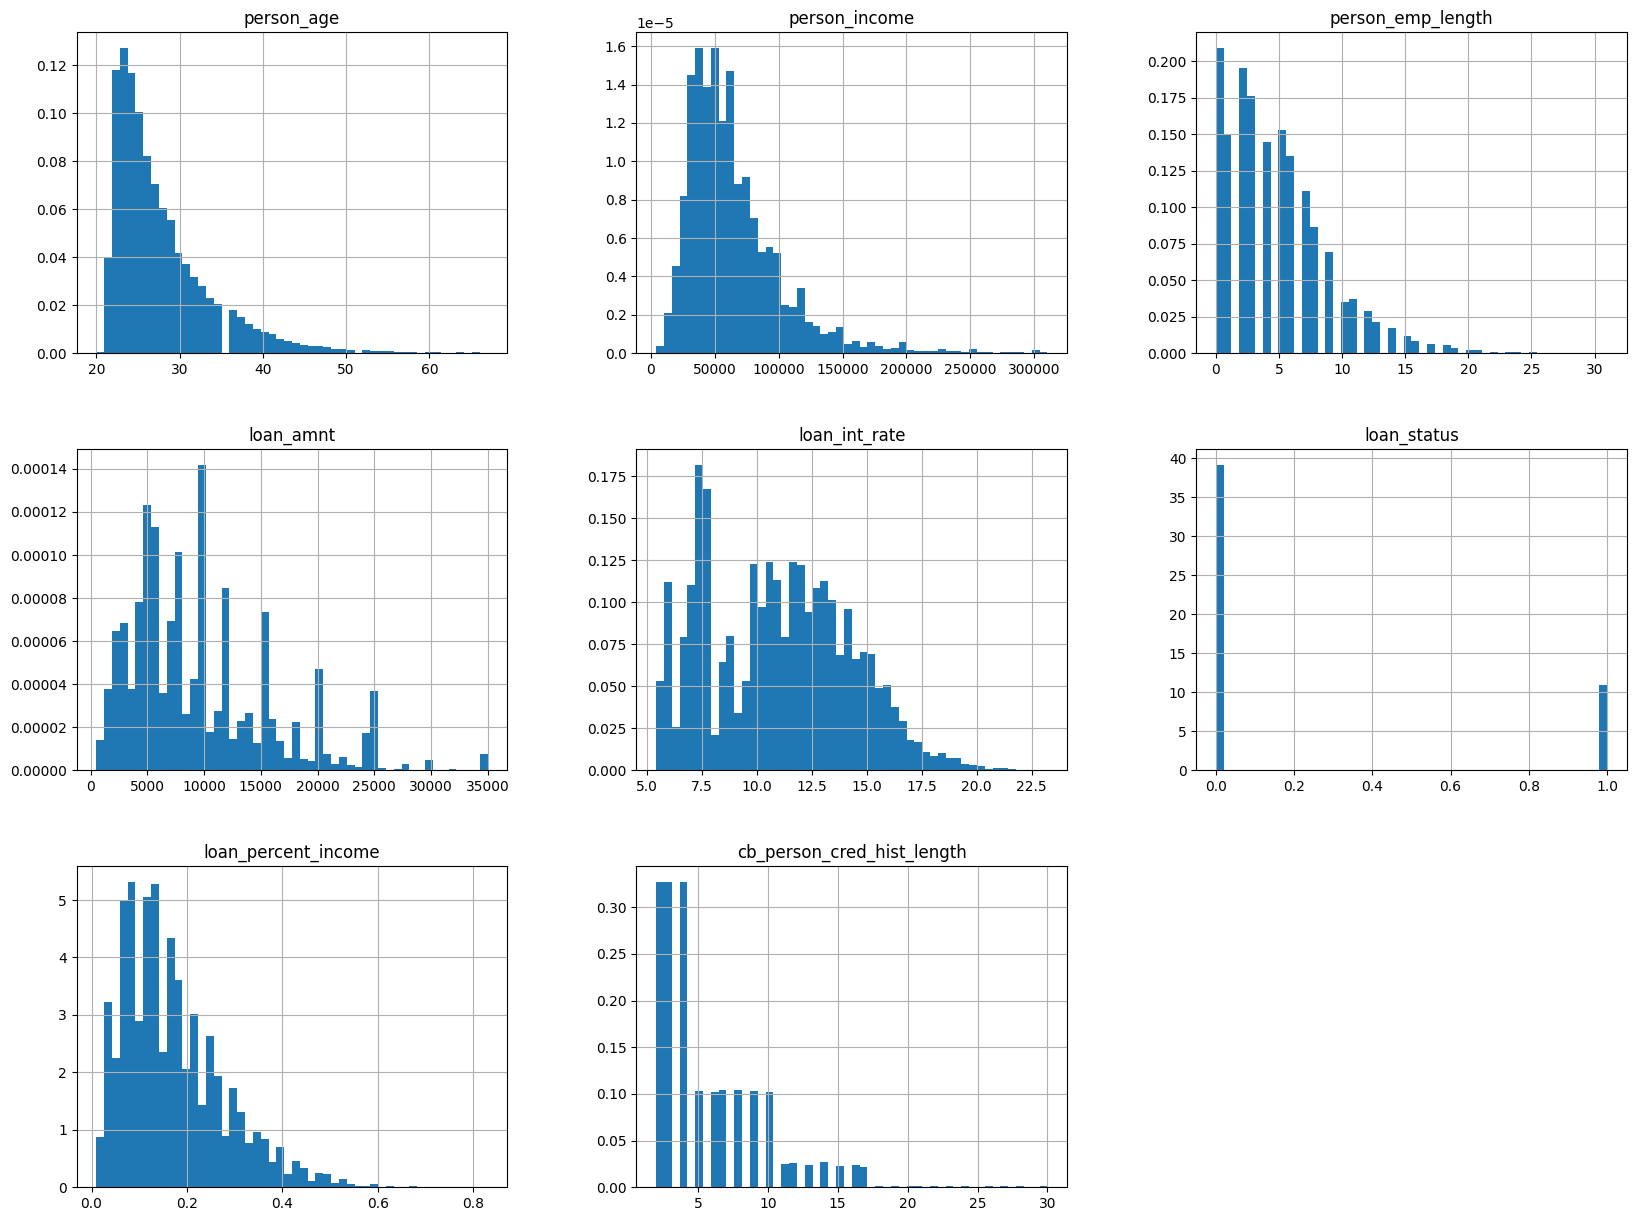

In [73]:
# Plot data when outliers are removed
df_data_clean.hist(bins=50, figsize=(20,15), density = True)
plt.show()

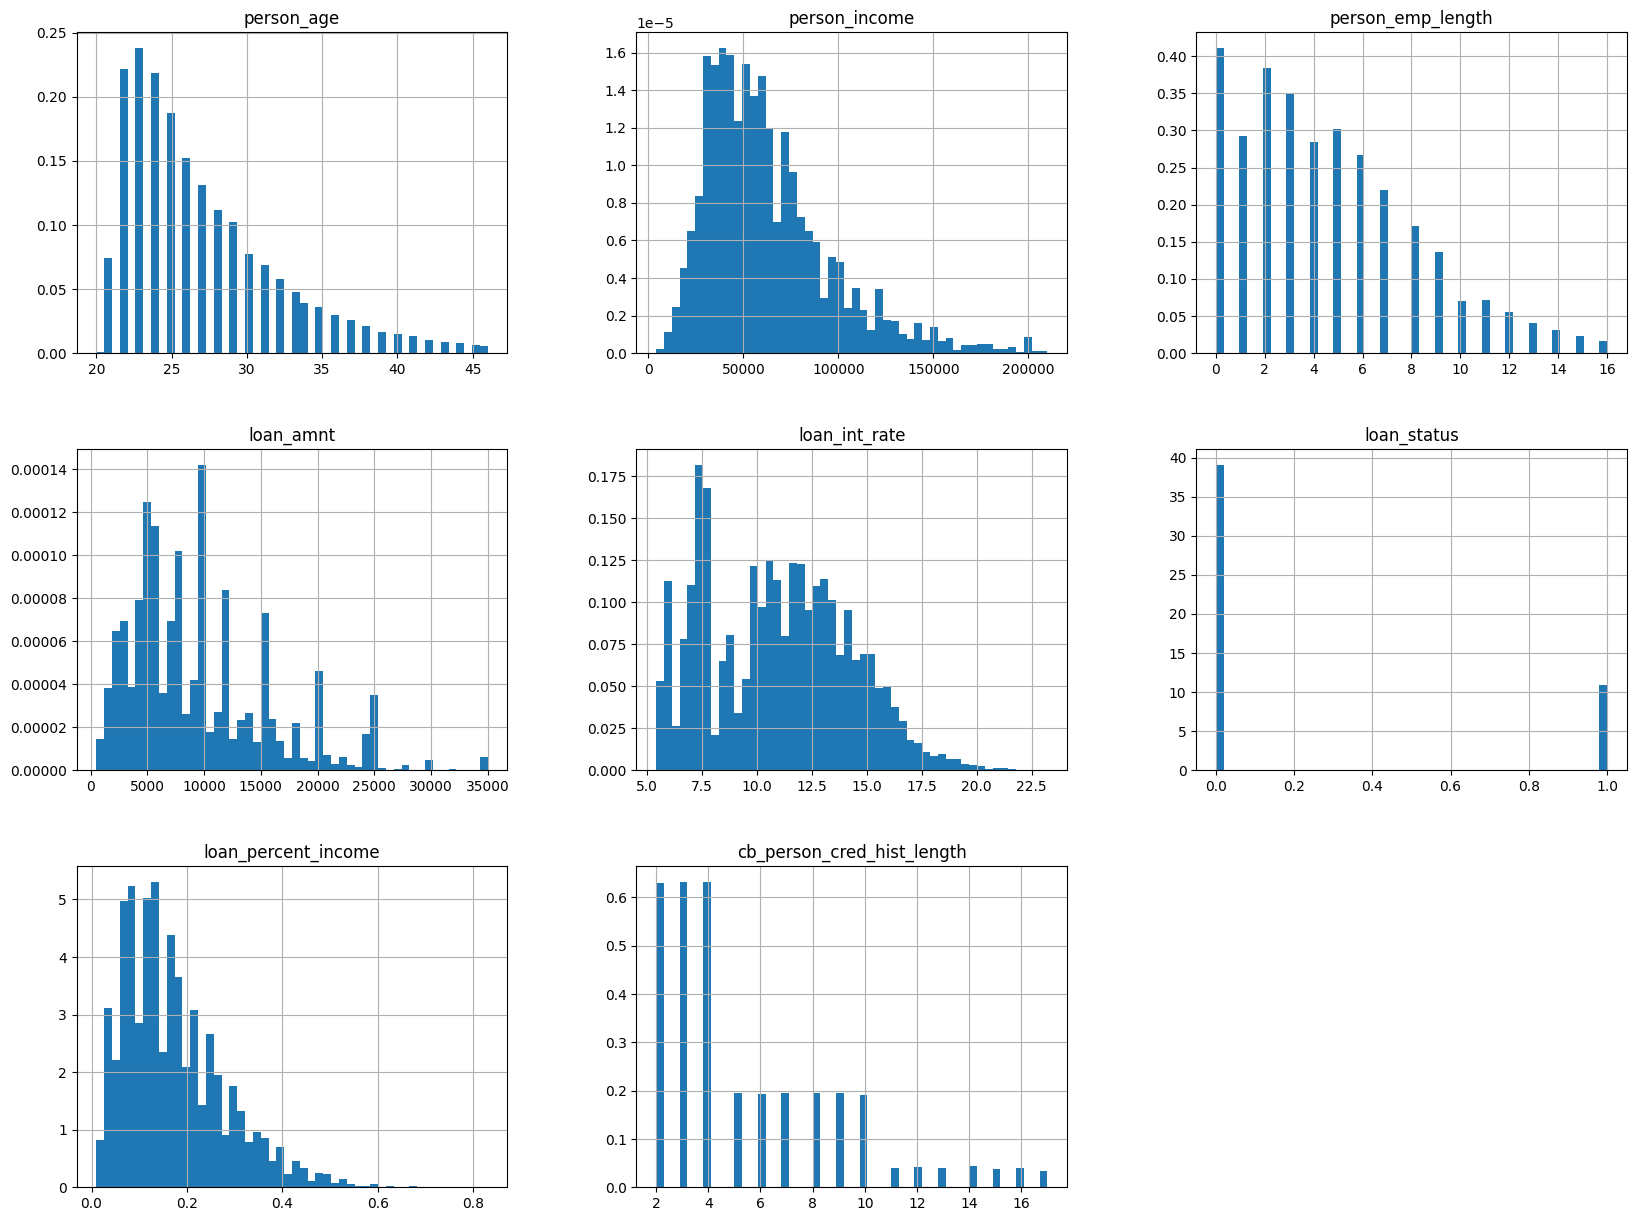

In [25]:
df_data_clean2.hist(bins=50, figsize=(20,15), density = True)
plt.show()

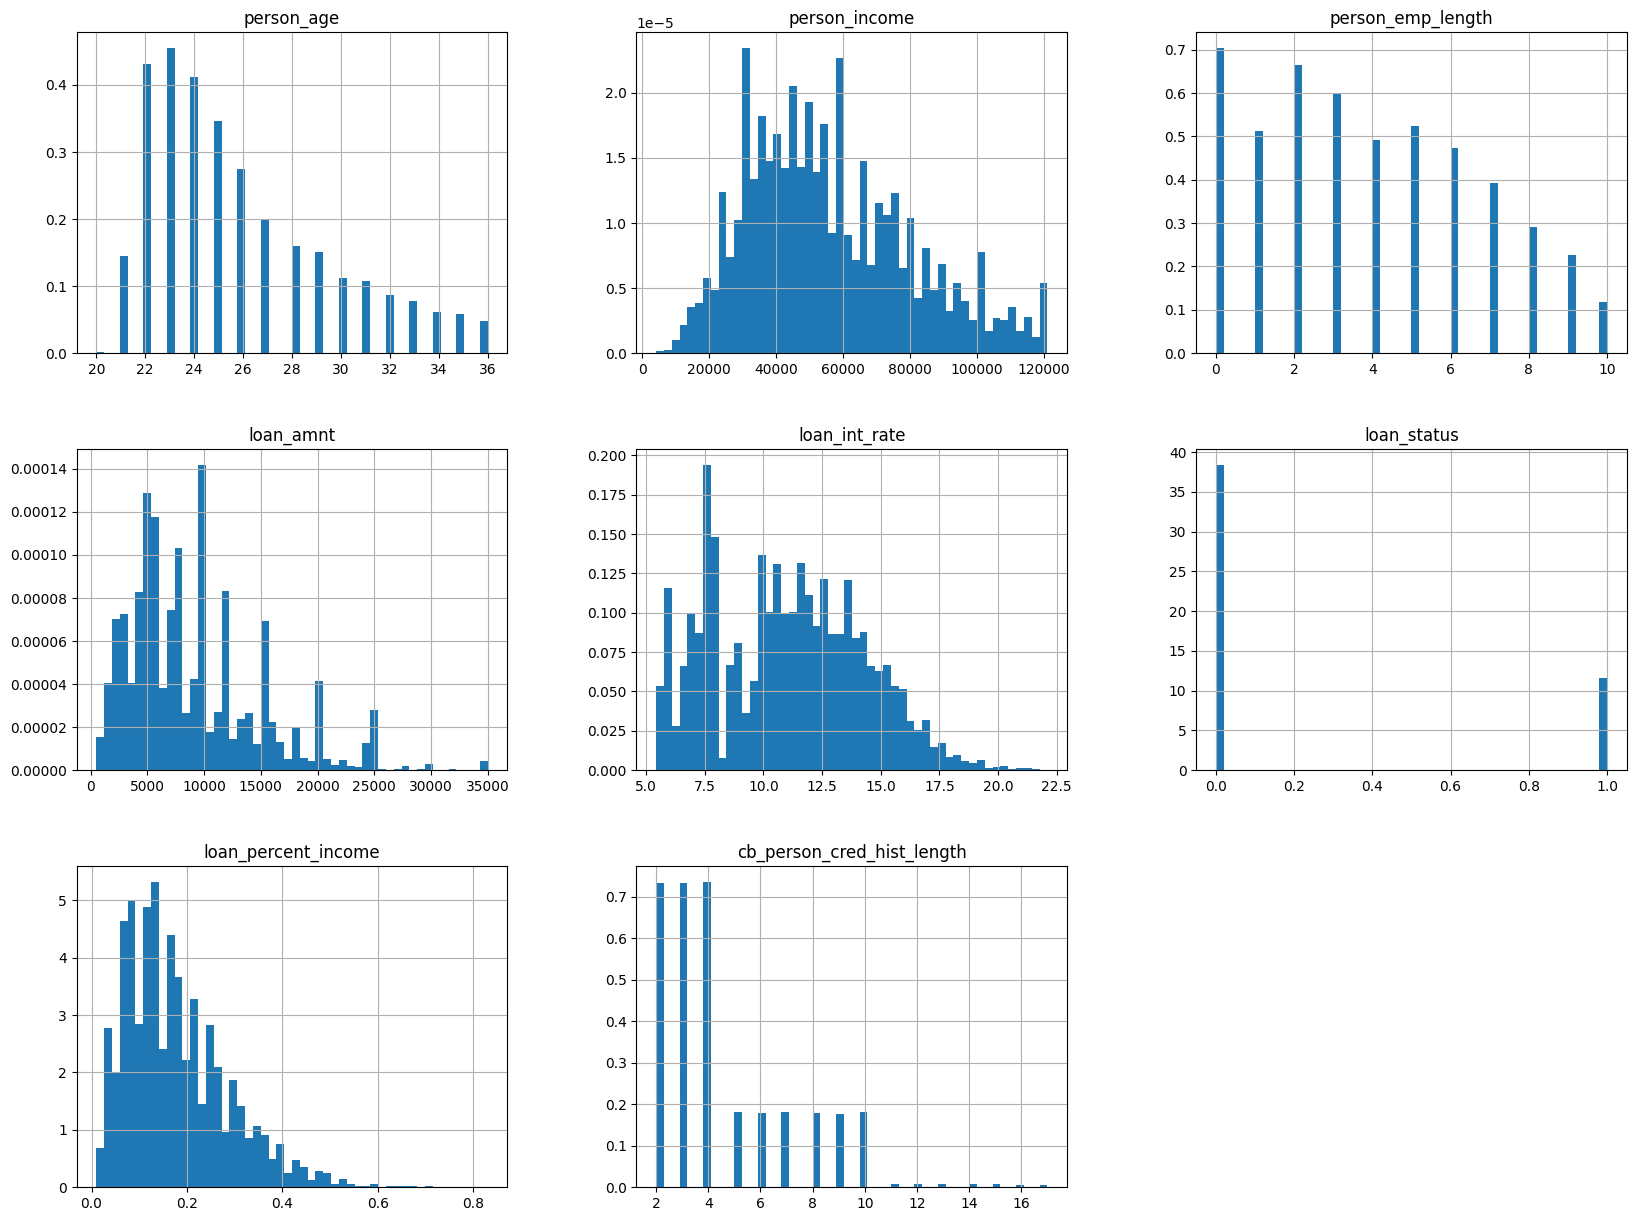

20

In [26]:
df_data_clean3.hist(bins=50, figsize=(20,15), density = True)
plt.show()
df_data_clean3['person_age'].min() 

#### 2. Predicted attribute (Prognozuojamas atributas) - loan_grade

In [65]:
# Chose the predictive attribute loan_grade
X = df_data_clean.drop("loan_grade", axis=1) # Drop the target variable loan_grade
y = df_data_clean["loan_grade"] # Target variable is loan_grade

In [66]:
# Encode the target variable loan_grade as an integer using LabelEncoder 
le = LabelEncoder() # Create a label encoder object
y = le.fit_transform(y) # Fit the label encoder and transform the target variable

#### 3-4 Split the data into train and test sets (Duomenų rinkinio padalijimas į mokymo ir testavimo)

In [67]:
# Split the data into training and test sets (80% training and 20% test) (Duomenų rinkinio padalijimas į mokymo ir testavimo rinkinius)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### 5. Creating a decision tree model (Sprendimų medžio sudarymas)

In [68]:

# Creating categorical columns (Kategorinių stulpelių sudarymas)
le = LabelEncoder() # Sukuriamas LabelEncoder objektas
X_train = X_train.apply(le.fit_transform) # Pritaikomas LabelEncoder objektas ir transformuojami duomenys
X_test = X_test.apply(le.fit_transform) # Pritaikomas LabelEncoder objektas ir transformuojami duomenys
# Sukuriamas Decision Tree modelis su Gini impurity
clf= DecisionTreeClassifier(criterion="gini", random_state=42) # Sukuriamas Decision Tree modelis su Gini impurity 
clf.fit(X_train, y_train) # Mokymosi algoritmas


DecisionTreeClassifier(random_state=42)

#### 6. Decision tree visualization  (Sprendimų medžio vizualizacija) 

In [74]:
unique_classes = np.unique(y) # Get the unique classes in the target variable (Gauti unikalias reikšmes)
str_unique_classes = [str(x) for x in unique_classes] # Convert the unique classes to string (Konvertuoti unikalias klasifikatorių reikšmes į string tipo reikšmes)
dot_data = export_graphviz(clf, out_file=None, feature_names=X.columns, class_names = str_unique_classes , filled=True, rounded=True, special_characters=True) # Export the decision tree to a dot file
graph = graphviz.Source(dot_data) # Create a graph from dot file
graph.render("decision_tree1")  # Render the graph as a PDF file

'decision_tree1.pdf'

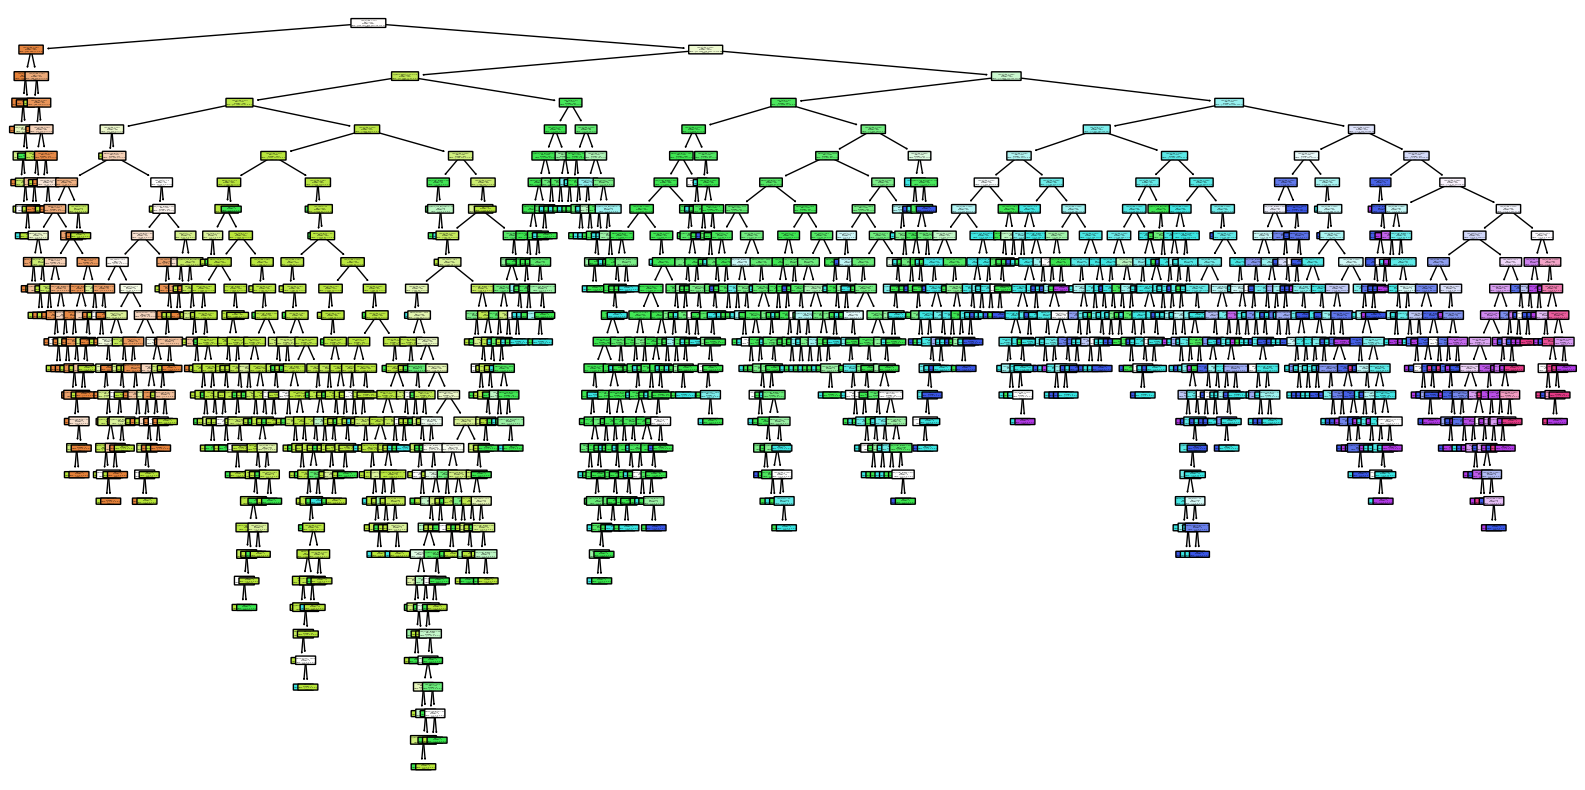

In [75]:
plt.figure(figsize =(20,10))
plot_tree(clf, filled= True, rounded= True, class_names= ['A', 'B', 'C', 'D', 'E', 'F', 'G'], feature_names= X.columns)
plt.show()

### 7. Testing of decision tree model (Sprendimų medžio testavimas)

In [79]:
# Prognozuojame testavimo duomenis 
y_pred = clf.predict(X_test)

# Apskaiciuojmas  modelio tikslumas
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100 :.4f} ")

# Apskaiciuojamos paklaidos (mae, mse, rse)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rse = r2_score (y_test, y_pred)
print(f"Mean Absolute Error: {mae: .4f}")
print(f"Mean Squared Error: {mse: .4f}")
print(f"Root Squared Error: {rse: .4f}")

# Apskaiciuojama confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n {conf_matrix}")



Accuracy: 76.3901 
Mean Absolute Error:  0.2566
Mean Squared Error:  0.3005
Root Squared Error:  0.7781
Confusion Matrix:
 [[1654  213    0    0    0    0    0]
 [  47 1465  316   23    0    0    0]
 [   0   93  862  163   15    0    0]
 [   0    5  225  330   72    4    0]
 [   0    1   31   92   38    1    3]
 [   0    0    1    8   12    6    0]
 [   0    0    0    6   12    3    0]]


#### 8. Keičiant maksimalų medžio gylį, eksperimentiniu būdu išmatuokite skirtingų gylių (3-4
#### variacijos) medžių formavimo trukmę bei gaunamą tikslumą, t.y. medžio auginimas stabdomas nuo tam tikro gylio

In [85]:
for max_depth in range(3, 7):
    clf_depth = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=max_depth) # Sukuriamas Decision Tree modelis su Gini impurity
    clf_depth.fit(X_train, y_train) # Mokymosi algoritmas
    y_pred = clf_depth.predict(X_test) # Prognozuojame testavimo duomenis
    accuracy = accuracy_score(y_test, y_pred) # Apskaiciuojmas  modelio tikslumas
    print(f"Accuracy for max_depth = {max_depth}: {accuracy * 100 :.4f} ") # Spausdinamas modelio tikslumas



Accuracy for max_depth = 3: 83.2486 
Accuracy for max_depth = 4: 83.7748 
Accuracy for max_depth = 5: 83.0381 
Accuracy for max_depth = 6: 81.8102 


#### 9. Creating Random Forest model (Suformuoti random forest modelį, su 5 medziais)

In [88]:
# Parenkamas maksimalus medžio gylis pagal geriausius rezultatus, pvz., 5
best_depth = 5

# Sukuriamas RandomForestClassifier su 5 medžiais 
rf_clf = RandomForestClassifier(n_estimators=5, max_depth=best_depth, random_state=42)

# Apmokomas atsitiktinis miškas su duomenimis
rf_clf.fit(X_train, y_train)

# Testavimo duomenys
y_pred_rf = rf_clf.predict(X_test)

# Apskaiciuotas atsitiktinio miško tikslumas
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Random Forest): {accuracy_rf * 100 :.4f} ")

# Apskaiciuotos paklaidos (mae, mse, rmse)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f"Mean Absolute Error (Random Forest): {mae_rf: .4f}")
print(f"Mean Squared Error (Random Forest): {mse_rf: .4f}")
print(f"Root Mean Squared Error (Random Forest): {rmse_rf: .4f}")

# Apskaiciuota susimaišymo matricą
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(f"Confusion Matrix (Random Forest):\n{confusion_matrix_rf}")


Accuracy (Random Forest): 82.8451 
Mean Absolute Error (Random Forest):  0.1987
Mean Squared Error (Random Forest):  0.2661
Root Mean Squared Error (Random Forest):  0.5158
Confusion Matrix (Random Forest):
[[1773   94    0    0    0    0    0]
 [  55 1796    0    0    0    0    0]
 [   1  217  885   30    0    0    0]
 [   1   12  354  269    0    0    0]
 [   1    1   56  108    0    0    0]
 [   0    1    8   18    0    0    0]
 [   0    0    0   21    0    0    0]]


#### 10. Testavimas su random forest dydžiu [3-9]

In [89]:
for n_trees in range(3,10):
    rf_trees = RandomForestClassifier(n_estimators=n_trees, criterion="gini", max_depth = best_depth, random_state=42) # Sukuriamas Random Forest su n_trees medžiais
    rf_trees.fit(X_train, y_train)  # Apmokomi duomenys
    y_pred_trees = rf_trees.predict(X_test) # Testavimo duomenys
    accuracy_trees = accuracy_score(y_test, y_pred_trees) # Apskaiciuojamas tikslumas
    print(f"Number of trees : {n_trees}, Accuracy: {accuracy_trees * 100 :.4f} ")


Number of trees : 3, Accuracy: 79.3896 
Number of trees : 4, Accuracy: 80.1438 
Number of trees : 5, Accuracy: 82.8451 
Number of trees : 6, Accuracy: 83.4240 
Number of trees : 7, Accuracy: 83.6871 
Number of trees : 8, Accuracy: 83.1959 
Number of trees : 9, Accuracy: 83.6520 


#### 11. Comparison for Decision trees and Random forest models (Rezultatų palyginimas Decision trees ir Random forest modelių) 

In [91]:
print(f"Decission Tree Accuracy : {accuracy * 100 :.4f} ") # Spausdinamas Decision Tree tikslumas
print(f"Random Forest Accuracy : {accuracy_trees * 100 :.4f} ") # Spausdinamas Random Forest tikslumas

Decission Tree Accuracy : 82.8451 
Random Forest Accuracy : 83.6520 


In [93]:

# Tikslumo metrikos
dt_accuracy = accuracy
rf_accuracy = accuracy_trees

# Bar chart su modelių tikslumo metrikomis
trace1 = go.Bar(
    x=['Decision Tree', 'Random Forest'],
    y=[dt_accuracy, rf_accuracy],
    text=[f'{dt_accuracy:.2f}', f'{rf_accuracy:.2f}'],
    textposition='auto',
    marker=dict(color=['#1f77b4', '#ff7f0e'])
)

data = [trace1]
layout = go.Layout(
    title='Modelių tikslumo palyginimas',
    xaxis=dict(title='Modeliai'),
    yaxis=dict(title='Tikslumas')
)

fig = go.Figure(data=data, layout=layout)
fig.show()
